<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/Copy_of_Numerai_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making your first submission on Numerai

## Introduction 
This tutorial will go over how to create your first submission on Numerai.

## Overview

1. Using this notebook
2. Download the datasets
3. Train your first model
4. Generate your first predictions
4. Make your first submission


---



## 1. Using this notebook 

This is an interactive notebook. You can execute code in each cell by pressing `shift+enter`. This requires you to login with your Google account.

In order to make changes, you need to make a copy by `File -> Save a copy in Drive`.

Let's start off by installing and importing our dependencies.

In [ ]:
# install dependencies
%%capture
!pip install pandas sklearn numerapi

In [ ]:
# import dependencies
import pandas as pd
import numerapi
import sklearn.linear_model

In [ ]:
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor

In [ ]:
# Imports for Kfold cross validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

## 2. Download the datasets

### Datasets 
*   `training_data` is used to train your model
*   `tournament_data` is used to evaluate your model

### Column descriptions
*   id: a randomized id that corresponds to a stock 
*   era: a period of time
*   data_type: either `train`, `validation`, `test`, or `live` 
*   feature_*: abstract financial features of the stock 
*   target: abstract measure of stock performance




In [ ]:
# download the latest training dataset (takes around 30s)
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz")
training_data.head(3)

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.5,0.25,0.00,0.5,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.0,0.75,0.5,1.0,0.5,0.0,0.50,0.50,0.00,0.0,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.5,0.50,0.75,0.5,...,0.75,0.75,0.75,0.5,1.0,1.0,0.5,0.75,0.5,0.25,0.25,0.75,0.5,1.0,0.5,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.0,0.25,0.5,0.50,0.50,0.75,1.00,1.00,1.0,0.75,0.5,0.75,0.50,1.0,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.0,0.00,0.25,0.5,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.0,0.50,0.5,0.5,0.5,0.5,0.25,0.25,0.50,0.0,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.5,0.25,0.75,0.5,...,0.25,0.25,0.25,1.0,1.0,0.5,0.5,0.50,0.0,0.25,1.00,0.50,1.0,1.0,0.5,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.0,0.50,0.5,0.50,0.75,0.75,0.75,1.00,1.0,0.00,0.0,0.75,0.25,0.0,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.5,0.25,0.25,1.0,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.5,0.75,0.5,0.5,1.0,0.5,0.50,0.50,0.25,0.0,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.5,0.50,0.75,0.5,...,0.25,1.00,1.00,1.0,0.5,1.0,1.0,1.00,0.5,1.00,0.00,1.00,1.0,0.5,1.0,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.5,0.75,1.0,0.75,1.00,0.25,0.50,0.25,0.5,0.00,0.0,0.50,1.00,0.0,0.25,0.75,0.25


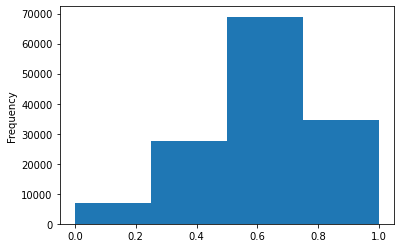

In [ ]:
tournament_data['target'].plot.hist(bins=4)

In [ ]:
# download the latest tournament dataset (takes around 30s)
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
tournament_data.head(3)

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.5,0.0,0.75,0.5,0.25,0.50,0.5,0.25,0.0,0.25,0.50,0.25,0.0,0.25,1.00,1.00,0.25,1.0,1.00,0.25,0.25,0.0,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.0,...,0.00,0.0,0.25,0.5,0.25,0.25,0.00,0.25,0.0,0.25,0.5,0.50,0.50,0.5,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.5,0.25,0.5,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.0,0.0,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.0,0.5,0.00,0.0,0.75,0.25,0.0,0.75,0.5,0.00,0.25,0.50,0.0,1.00,0.25,0.25,1.00,1.0,0.25,0.75,0.00,0.0,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.0,...,0.50,0.5,0.25,1.0,0.50,0.25,0.00,0.25,0.5,0.25,1.0,0.25,0.00,0.5,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.5,0.50,0.5,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.5,0.5,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.0,1.0,1.00,1.0,1.00,0.50,0.5,1.00,1.0,1.00,0.75,0.50,0.5,1.00,1.00,0.50,0.50,0.0,1.00,0.50,1.00,0.5,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.0,...,0.25,0.5,0.00,0.0,0.00,0.25,0.25,0.00,0.5,0.00,0.0,0.00,0.25,0.0,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.0,0.75,0.0,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.5,0.0,1.00


## 3. Train your first model
Let's create a basic model using sklearn's linear regression.

In [ ]:
# find only the feature columns
feature_cols = training_data.columns[training_data.columns.str.startswith('feature')]

In [ ]:
# select those columns out of the training dataset
training_features = training_data[feature_cols]

In [ ]:
# fit model to training data
model_XGB = XGBRegressor(tree_method='gpu_hist', gpu_id=0, n_estimators=100)

In [ ]:
model_XGB.fit(training_features, training_data.target)

[23:03:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [ ]:
features_xgb = model_XGB.feature_importances_
print(np.flip(np.sort(features_xgb))) # Relative importance of the features

[0.00685067 0.00646961 0.00632742 0.00614555 0.00559613 0.00553181
 0.00549878 0.0054621  0.00537818 0.00535626 0.00534484 0.0053438
 0.00519448 0.00510443 0.00510325 0.0049867  0.00498455 0.00496002
 0.00487402 0.00486501 0.00483175 0.00480964 0.00480383 0.00474354
 0.00472528 0.00470333 0.00468045 0.00462913 0.004572   0.00445584
 0.00445579 0.00444953 0.0044119  0.00439405 0.00435526 0.00433155
 0.00432542 0.00432528 0.00432497 0.00424894 0.0042109  0.00416088
 0.00410392 0.00409443 0.00403604 0.00402788 0.00400629 0.00399618
 0.00398591 0.00398388 0.00395536 0.00393041 0.00392554 0.00390678
 0.00389591 0.00388821 0.00383566 0.00382518 0.00381583 0.00381516
 0.00380679 0.00376743 0.00376338 0.00374995 0.00374662 0.00374428
 0.00373419 0.00373096 0.00372236 0.00371498 0.00371465 0.00371338
 0.00371195 0.00370302 0.00370286 0.00370179 0.00368308 0.00368133
 0.00366647 0.00364889 0.00364178 0.00364163 0.0036311  0.00361735
 0.00360499 0.00358449 0.00357584 0.00356084 0.00355224 0.00353

In [ ]:
y_pred = model_XGB.predict(training_features[0:100])

In [ ]:
y_pred

array([0.49473107, 0.5024325 , 0.4829124 , 0.5074103 , 0.49180755,
       0.511857  , 0.5163623 , 0.47789553, 0.46930793, 0.527829  ,
       0.50570256, 0.4794862 , 0.5003559 , 0.4787444 , 0.5195866 ,
       0.46909776, 0.5029506 , 0.5142443 , 0.48793197, 0.5209099 ,
       0.507942  , 0.49485996, 0.496894  , 0.5033568 , 0.51548797,
       0.45400992, 0.528881  , 0.4905038 , 0.48753375, 0.5068872 ,
       0.4940042 , 0.5089081 , 0.50891703, 0.5026929 , 0.51789457,
       0.5100772 , 0.4772086 , 0.5099623 , 0.48448557, 0.5139777 ,
       0.51050925, 0.5062539 , 0.5031444 , 0.5297791 , 0.48170602,
       0.4493713 , 0.47421116, 0.49379224, 0.5147847 , 0.4937884 ,
       0.51463175, 0.48092183, 0.5206769 , 0.48007932, 0.51324517,
       0.48579472, 0.4811805 , 0.49355268, 0.53932345, 0.51714146,
       0.49795792, 0.49723434, 0.48253644, 0.49712652, 0.49911416,
       0.49007493, 0.49560466, 0.5099816 , 0.4758219 , 0.5166905 ,
       0.519258  , 0.47822177, 0.5076828 , 0.48776764, 0.46963

## 4. Generate your first predictions
Now that we have a trained model, we can use it to make predictions on the tournament data.



In [ ]:
# select the feature columns from the tournament data
live_features = tournament_data[feature_cols]

In [ ]:
# predict the target on the live features
predictions = model.predict(live_features)

In [ ]:
# predictions must have an `id` column and a `prediction_kazutsugi` column
predictions_df = tournament_data["id"].to_frame()
predictions_df["prediction_kazutsugi"] = predictions
predictions_df.head()

,id,prediction_kazutsugi
0,n0003aa52cab36c2,0.472981
1,n000920ed083903f,0.492854
2,n0038e640522c4a6,0.556868
3,n004ac94a87dc54b,0.496384
4,n0052fe97ea0c05f,0.497034


## 5. Make your first submission
To enter the tournament, we must submit the predictions back to Numerai. We will use the `numerapi` library to do this.

In [ ]:
# Get your API keys and model_id from https://numer.ai/submit
public_id = "REPLACEME"
secret_key = "REPLACEME"
model_id = "REPLACEME"
napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)

In [ ]:
# Upload your predictions
predictions_df.to_csv("predictions.csv", index=False)
submission_id = napi.upload_predictions("predictions.csv", model_id=model_id)

# Done 🚀
Good job! You just made your first submission on Numerai!

Head back over to https://numer.ai/submit to continue.